# Team 3 Final Project
## CS486 - Ethical and Trustworthy AI Fall 2025
###### Timothy George (tmgeorge2@dons.usfca.edu), Smrithi Panuganti (spanuganti@dons.usfca.edu), David Shubov (drshubov@dons.usfca.edu)

## Audit of Original Data

In [20]:
import pandas as pd                 # data manipulation
import numpy as np                  # numerical operations
import matplotlib.pyplot as plt     # basic plotting
import seaborn as sns               # statistical viz
# Import necessary modules from scikit-learn for model building and evaluation
from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report

sns.set(color_codes=True)           # allow for use of shorthand color codes

In [21]:
# Import necessary libraries for Google Drive interaction and file path manipulation
from google.colab import drive
import os

# Mount Google Drive to access files
drive.mount('/content/drive', force_remount=True)

# Define the project folder path on Google Drive
project_folder = "/content/drive/My Drive/EthicalAI"

Mounted at /content/drive


In [22]:
# Construct the full file path to the dataset
file_path = os.path.join(project_folder, "heart_disease_uci_cleaned.csv")

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(file_path)

In [23]:
print(df.shape)
df.head(5)

(920, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,63,Male,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,67,Male,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,67,Male,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,37,Male,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,41,Female,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [24]:
# Assign the DataFrame to a variable named data
data = df

# Print the shape of the data (number of rows and columns)
print("Data shape:", data.shape)
# Print the number of columns
print("Columns:", len(data.columns))
# Print descriptive statistics of the data
print(data.describe())
# Print the counts of each unique value in the "Label" column
print(data["num"].value_counts())

Data shape: (920, 14)
Columns: 14
              age    trestbps        chol      thalch     oldpeak          ca  \
count  920.000000  920.000000  920.000000  920.000000  920.000000  920.000000   
mean    53.510870  131.995652  199.908696  137.692391    0.853261    0.227174   
std      9.424685   18.451300  109.040171   25.145235    1.058049    0.628936   
min     28.000000    0.000000    0.000000   60.000000   -2.600000    0.000000   
25%     47.000000  120.000000  177.750000  120.000000    0.000000    0.000000   
50%     54.000000  130.000000  223.000000  140.000000    0.500000    0.000000   
75%     60.000000  140.000000  267.000000  156.000000    1.500000    0.000000   
max     77.000000  200.000000  603.000000  202.000000    6.200000    3.000000   

              num  
count  920.000000  
mean     0.995652  
std      1.142693  
min      0.000000  
25%      0.000000  
50%      1.000000  
75%      2.000000  
max      4.000000  
num
0    411
1    265
2    109
3    107
4     28
Name: c

In [25]:
# Display concise information about the DataFrame, including data types and non-null values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       920 non-null    int64  
 1   sex       920 non-null    object 
 2   cp        920 non-null    object 
 3   trestbps  920 non-null    float64
 4   chol      920 non-null    float64
 5   fbs       920 non-null    bool   
 6   restecg   920 non-null    object 
 7   thalch    920 non-null    float64
 8   exang     920 non-null    bool   
 9   oldpeak   920 non-null    float64
 10  slope     920 non-null    object 
 11  ca        920 non-null    float64
 12  thal      920 non-null    object 
 13  num       920 non-null    int64  
dtypes: bool(2), float64(5), int64(2), object(5)
memory usage: 88.2+ KB


## Creation of training DB and verification DB

In [29]:
data = df.copy()
# Handle categorical variables for the heart disease dataset
categorical_cols = [
    "sex", "cp", "fbs", "restecg",
    "exang", "slope", "ca", "thal"
]
# Clean and encode categorical and numeric columns properly
for col in categorical_cols:
    if col in data.columns:
        data[col] = data[col].astype(str).str.strip()  # ensure clean strings

# Detect non-numeric columns that are *not* in categorical_cols
non_numeric = [c for c in data.columns if data[c].dtype == 'object' and c not in categorical_cols]

# Try converting these to numeric (e.g. if 'ca' or 'thal' have '?')
for c in non_numeric:
    data[c] = pd.to_numeric(data[c], errors='coerce')

# Drop rows that became NaN after coercion (invalid numbers)
data = data.dropna()

# One-hot encode categorical features
data_encoded = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

print("Categorical columns after update:", categorical_cols)
print("Shape of data_encoded after one-hot encoding:", data_encoded.shape)
print("First 5 rows of data_encoded:\n", data_encoded.head())

Categorical columns after update: ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
Shape of data_encoded after one-hot encoding: (920, 21)
First 5 rows of data_encoded:
    age  trestbps   chol  thalch  oldpeak  num  sex_Male  cp_atypical angina  \
0   63     145.0  233.0   150.0      2.3    0      True               False   
1   67     160.0  286.0   108.0      1.5    2      True               False   
2   67     120.0  229.0   129.0      2.6    1      True               False   
3   37     130.0  250.0   187.0      3.5    0      True               False   
4   41     130.0  204.0   172.0      1.4    0     False                True   

   cp_non-anginal  cp_typical angina  ...  restecg_normal  \
0           False               True  ...           False   
1           False              False  ...           False   
2           False              False  ...           False   
3            True              False  ...            True   
4           False              Fals

In [30]:
# Select 1 positive and 1 negative sample randomly for a Verification DB
pos_sample = data_encoded[data_encoded["num"] == 1].sample(1, random_state=42)
neg_sample = data_encoded[data_encoded["num"] == 0].sample(1, random_state=42)
verification_db = pd.concat([pos_sample, neg_sample])

# Remove the selected samples from the original data to create the Training DB
train_db = data_encoded.drop(verification_db.index)

# Print the shapes of the Training and Verification DataFrames
print("Training DB shape:", train_db.shape)
print("Verification DB shape:", verification_db.shape)

# Separate features (X) and labels (y) for the Training DB
X = train_db.drop("num", axis=1)
y = train_db["num"]

# Display the Training DB
print("Training DB describe: \n")
train_db

Training DB shape: (918, 21)
Verification DB shape: (2, 21)
Training DB describe: 



,age,trestbps,chol,thalch,oldpeak,num,sex_Male,cp_atypical angina,cp_non-anginal,cp_typical angina,...,restecg_normal,restecg_st-t abnormality,exang_True,slope_flat,slope_upsloping,ca_1.0,ca_2.0,ca_3.0,thal_normal,thal_reversable defect
0,63,145.0,233.0,150.0,2.3,0,True,False,False,True,...,False,False,False,False,False,False,False,False,False,False
1,67,160.0,286.0,108.0,1.5,2,True,False,False,False,...,False,False,True,True,False,False,False,True,True,False
2,67,120.0,229.0,129.0,2.6,1,True,False,False,False,...,False,False,True,True,False,False,True,False,False,True
3,37,130.0,250.0,187.0,3.5,0,True,False,True,False,...,True,False,False,False,False,False,False,False,True,False
4,41,130.0,204.0,172.0,1.4,0,False,True,False,False,...,False,False,False,False,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,54,127.0,333.0,154.0,0.0,1,False,False,False,False,...,False,True,False,True,False,False,False,False,True,False
916,62,130.0,139.0,140.0,0.5,0,True,False,False,True,...,False,True,False,True,False,False,False,False,True,False
917,55,122.0,223.0,100.0,0.0,2,True,False,False,False,...,False,True,False,True,False,False,False,False,False,False
918,58,130.0,385.0,140.0,0.5,0,True,False,False,False,...,False,False,False,True,False,False,False,False,True,False


**Reasoning**:
The previous step successfully created the `train_db`, `verification_db`, `X`, and `y` DataFrames. Now, as per the instructions, I need to execute cell `4diGB_4wHy4X` to display the `verification_db` DataFrame.



In [31]:
# Display the Verification DB
print("Verification DB describe: \n")
verification_db

Verification DB describe: 



,age,trestbps,chol,thalch,oldpeak,num,sex_Male,cp_atypical angina,cp_non-anginal,cp_typical angina,...,restecg_normal,restecg_st-t abnormality,exang_True,slope_flat,slope_upsloping,ca_1.0,ca_2.0,ca_3.0,thal_normal,thal_reversable defect
649,55,115.0,0.0,155.0,0.1,1,True,False,False,False,...,True,False,False,True,False,False,False,False,True,False
312,34,130.0,161.0,190.0,0.0,0,False,True,False,False,...,True,False,False,True,False,False,False,False,True,False


num
0    411
1    265
2    109
3    107
4     28
Name: count, dtype: int64
Class distribution (%):
num
0    44.673913
1    28.804348
2    11.847826
3    11.630435
4     3.043478
Name: count, dtype: float64


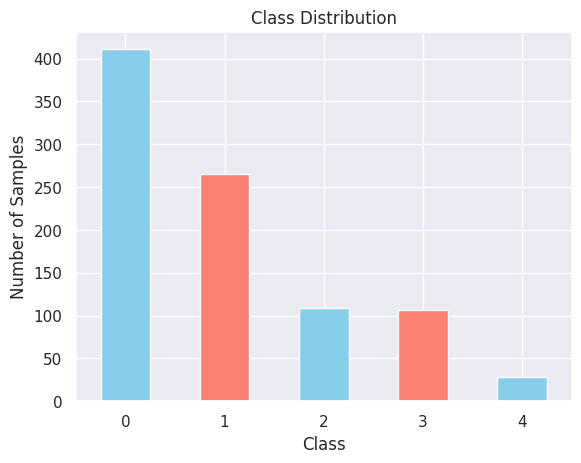

In [32]:
# Get the counts of each class in the "num" column
class_counts = data["num"].value_counts()
# Print the class counts
print(class_counts)

# Calculate and print the relative proportion of each class
print("Class distribution (%):")
print(class_counts / len(data) * 100)

# Plot the class distribution as a bar plot
class_counts.plot(kind="bar", color=["skyblue", "salmon"])
# Add title and labels to the plot
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.xticks(rotation=0)
# Display the plot
plt.show()

## Experimental Methods and Setup

In [35]:
# Define the hyperparameter grid for the Random Forest model
param_grid = {
    "n_estimators": [500, 1000, 2000],  # Number of trees in the forest
    "max_features": ["sqrt", "log2", 0.2, 0.5]  # Number of features to consider when looking for the best split
}
# Print the hyperparameter grid
print(param_grid)

{'n_estimators': [500, 1000, 2000], 'max_features': ['sqrt', 'log2', 0.2, 0.5]}


## Actual Results of RF Training and Accuracy Estimates

Best Parameters: {'n_estimators': 500, 'max_features': 'sqrt'}
Best Cross-Validation Accuracy (3-fold): 0.56645
Confusion Matrix:
 [[344  50  11   5   0]
 [ 87 141  17  17   2]
 [ 18  57  17  16   1]
 [ 16  56  17  17   1]
 [  5  11   4   7   1]]
Accuracy: 0.56645
Precision: 0.52426
Recall: 0.56645
F1 Score: 0.53761


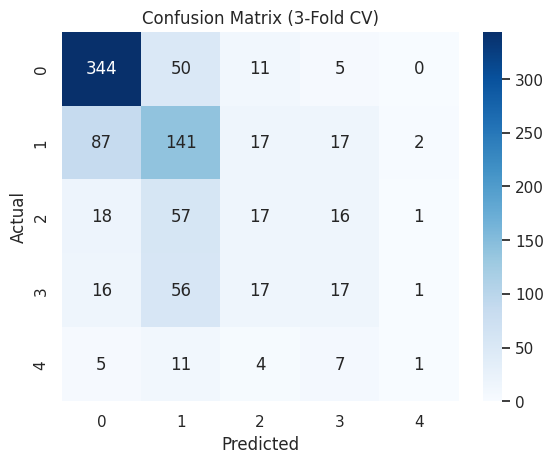

In [36]:
# Initialize StratifiedKFold for cross-validation, ensuring folds have similar class distribution
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Initialize variables to store the best model, score, and parameters
rf_model = None
score = 0
params = {}

# Iterate through hyperparameter combinations
for n in param_grid["n_estimators"]:
    for m in param_grid["max_features"]:
        # Initialize a Random Forest Classifier with current hyperparameters
        rf = RandomForestClassifier(n_estimators=n, max_features=m, random_state=42, n_jobs=-1)
        # Perform cross-validation and get predicted labels
        preds = cross_val_predict(rf, X, y, cv=skf)
        # Calculate accuracy
        acc = accuracy_score(y, preds)
        # Check if current accuracy is better than the best found so far
        if acc > score:
            # Update best score, model, and parameters
            score = acc
            rf_model = rf
            params = {"n_estimators": n, "max_features": m}

# Print the best hyperparameters and the corresponding cross-validation accuracy
print("Best Parameters:", params)
print("Best Cross-Validation Accuracy (3-fold):", f"{score:.5f}")

# Retrain the best model on the full training data
rf_model.fit(X, y)

# Evaluate the retrained model with cross-validation for detailed metrics
y_pred = cross_val_predict(rf_model, X, y, cv=skf)

# Calculate various evaluation metrics
cm = confusion_matrix(y, y_pred)
acc = accuracy_score(y, y_pred)
prec = precision_score(y, y_pred, average='weighted')  # supports multi-class
rec = recall_score(y, y_pred, average='weighted')
f1 = f1_score(y, y_pred, average='weighted')

# Print the evaluation metrics
print("Confusion Matrix:\n", cm)
print(f"Accuracy: {acc:.5f}")
print(f"Precision: {prec:.5f}")
print(f"Recall: {rec:.5f}")
print(f"F1 Score: {f1:.5f}")

# Plot the confusion matrix using a heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
# Add title and labels to the plot
plt.title("Confusion Matrix (3-Fold CV)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
# Display the plot
plt.show()

## Feature Ranking

Top 10 Features:
chol                  0.139660
age                   0.139397
thalch                0.138705
oldpeak               0.116137
trestbps              0.104360
exang_True            0.057207
cp_atypical angina    0.039036
cp_non-anginal        0.029880
sex_Male              0.028715
thal_normal           0.027686
dtype: float64


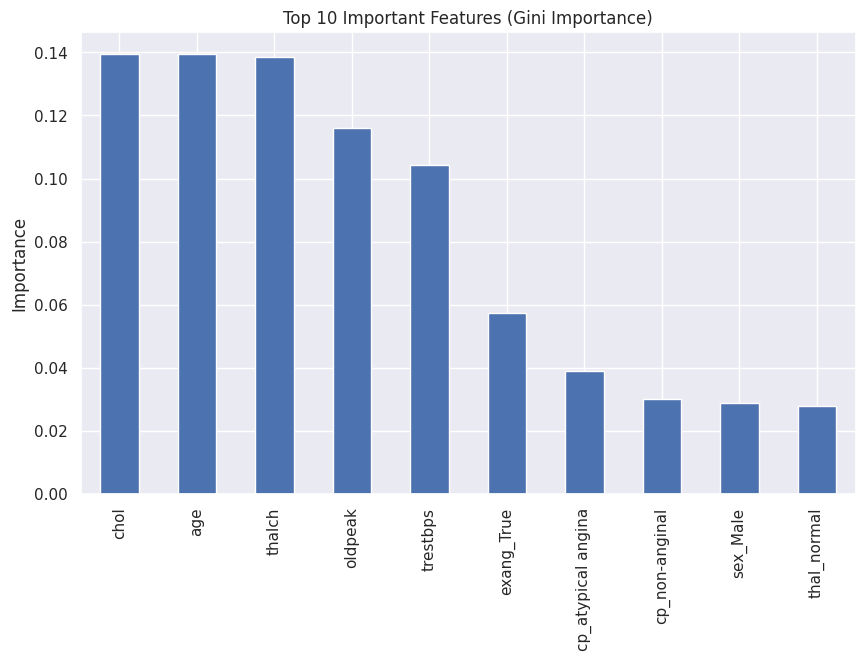

In [37]:
# Calculate feature importances from the trained Random Forest model
importances = pd.Series(rf_model.feature_importances_, index=X.columns)
# Get the top 10 most important features
top10 = importances.sort_values(ascending=False).head(10)

# Print the top 10 features and their importances
print("Top 10 Features:")
print(top10)

# Create a figure for the plot
plt.figure(figsize=(10,6))
# Plot the top 10 feature importances as a bar plot
top10.plot(kind="bar")
# Add title and labels to the plot
plt.title("Top 10 Important Features (Gini Importance)")
plt.ylabel("Importance")
# Display the plot
plt.show()

## RF Run Time Test

In [38]:
# Separate features (X) and labels (y) for the Verification DB
X_ver = verification_db.drop("num", axis=1)
y_ver = verification_db["num"]

# Make predictions on the Verification DB using the trained model
ver_preds = rf_model.predict(X_ver)
# Get the probability estimates for each class on the Verification DB
ver_probs = rf_model.predict_proba(X_ver)

# Create a DataFrame to display the verification results
results = pd.DataFrame({
    "True Label": y_ver.values,
    "Predicted Label": ver_preds,
    "Probability Class 0": ver_probs[:,0],
    "Probability Class 1": ver_probs[:,1]
})

# Print the verification results
print("Verification Results:")
print(results)

Verification Results:
   True Label  Predicted Label  Probability Class 0  Probability Class 1
0           1                1                0.150                0.424
1           0                0                0.974                0.026
